# Notebook demonstrates different approaches to SA

In [1]:
import sys 
sys.path.append('..')

from relu_nets import ReLUNet  
from hyperbox import Hyperbox  
from helper_functions_demo import *
from lipMIP import LipMIP
from other_methods import StochasticApproximationEqDiv, StochasticApproximationUCBDynamic

## Create 2D input space, large net

In [14]:
PIXELS = 500

In [3]:
DIMENSION = 2
rad = 5.0
domain = Hyperbox.build_custom_hypercube(DIMENSION, 0, rad)
network = ReLUNet([DIMENSION, 16, 16, 2])
c_vector = torch.Tensor([1.0, -1.0])

In [4]:
simple_prob = LipMIP(network, domain, c_vector, verbose=False, num_threads=5)
simple_result = simple_prob.compute_max_lipschitz()
LipMIP_result = simple_result.as_dict()["value"]
simple_result

LipMIP Result: 
	Value 0.268
	Runtime 0.152

maximum = 0.2683776617050171 on (3.4799999999998192 0.21999999999988873)


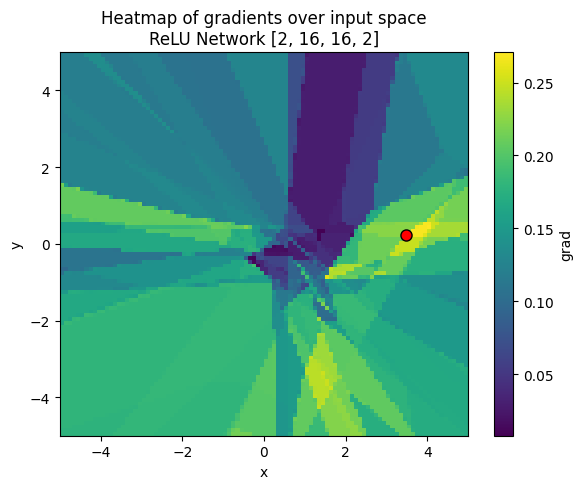

In [15]:
XS, GS, maximum, maximum_x, maximum_y = get_xs_gs_maximum(net=network, radius=rad, dimension=DIMENSION, px=PIXELS, c_vector=c_vector)
plot_grads(net=network, radius=rad, xs=XS, gs=GS, mxx=maximum_x, mxy=maximum_y)

## Stochastic Approximation with static input partition
Algorithm divides input space into fixed number of subregions and samples from each of them equally. 

### Compute result

In [16]:
SA_eq_div = StochasticApproximationEqDiv(network=network, c_vector=c_vector, domain=domain, divisions_per_dimension=5, use_c_vector=True)
eq_div_result = SA_eq_div.compute(v=False, total_iterations=10000, track_evaluations=True, exact=None)
print(f"SA with Equal space partition\n"
      f"\tresult = {eq_div_result}\n"
      f"\titerations = {SA_eq_div.iteration_count}\n"
      f"\tcompute time = {SA_eq_div.compute_time:.2f} seconds\n"
      f"\ton = {SA_eq_div.answer_coords}")

SA with Equal space partition
	result = 0.2683776617050171
	iterations = 10000
	compute time = 1.04 seconds
	on = [4.0115857 0.4324893]


### Division of the input space

In [17]:
print(f"rs = {eq_div_result}")
for region in SA_eq_div.regions:
    print(f"mx - {region.maximum}, n - {region.n} ---- lb & ub - {region.lb}, {region.ub}")

rs = 0.2683776617050171
mx - 0.18325506150722504, n - 400 ---- lb & ub - [-5. -5.], [-3. -3.]
mx - 0.18425486981868744, n - 400 ---- lb & ub - [-5. -3.], [-3. -1.]
mx - 0.2073499709367752, n - 400 ---- lb & ub - [-5. -1.], [-3.  1.]
mx - 0.2073499709367752, n - 400 ---- lb & ub - [-5.  1.], [-3.  3.]
mx - 0.13652445375919342, n - 400 ---- lb & ub - [-5.  3.], [-3.  5.]
mx - 0.18325506150722504, n - 400 ---- lb & ub - [-3. -5.], [-1. -3.]
mx - 0.18425486981868744, n - 400 ---- lb & ub - [-3. -3.], [-1. -1.]
mx - 0.20967724919319153, n - 400 ---- lb & ub - [-3. -1.], [-1.  1.]
mx - 0.13245856761932373, n - 400 ---- lb & ub - [-3.  1.], [-1.  3.]
mx - 0.13652445375919342, n - 400 ---- lb & ub - [-3.  3.], [-1.  5.]
mx - 0.21444258093833923, n - 400 ---- lb & ub - [-1. -5.], [ 1. -3.]
mx - 0.2033572793006897, n - 400 ---- lb & ub - [-1. -3.], [ 1. -1.]
mx - 0.22179004549980164, n - 400 ---- lb & ub - [-1. -1.], [1. 1.]
mx - 0.12793435156345367, n - 400 ---- lb & ub - [-1.  1.], [1. 3.]
mx 

## Stochastic Approximation with UCB, Dynamic partitioning

### Compute result

In [18]:
SA_ucb = StochasticApproximationUCBDynamic(network=network, c_vector=c_vector, domain=domain, c=15, partition_step=2, use_c_vector=True)
ucb_result = SA_ucb.compute(v=False, max_iter=1000, exact=None)
print(f"SA with MCTS\n"
      f"\tresult = {ucb_result})\n"
      f"\titerations = {SA_ucb.iteration_count}\n"
      f"\tcompute time = {SA_ucb.compute_time:.2f} seconds\n")

SA with MCTS
	result = tensor([0.2684]))
	iterations = 1000
	compute time = 0.15 seconds



### Division of the input space
Graph shows subregions of the input space

In [19]:
print(f"rs = {ucb_result}")
for region in SA_ucb.space.get_leaves():
    print(f"mx - {region.maximum}, n - {region.n} ---- l & r - {region.lb}, {region.ub}")

rs = tensor([0.2684])
mx - 0.1796652376651764, n - 11 ---- l & r - [-5. -5.], [-2.5 -2.5]
mx - 0.18425486981868744, n - 43 ---- l & r - [-5.  -2.5], [-2.5  0. ]
mx - 0.18325506150722504, n - 11 ---- l & r - [-2.5 -5. ], [ 0.  -2.5]
mx - 0.18425486981868744, n - 13 ---- l & r - [-2.5 -2.5], [-1.25  0.  ]
mx - 0.18325506150722504, n - 60 ---- l & r - [-1.25 -2.5 ], [0. 0.]
mx - 0.20967724919319153, n - 74 ---- l & r - [-5.  0.], [0. 5.]
mx - 0.24863290786743164, n - 176 ---- l & r - [ 0. -5.], [5. 0.]
mx - 0.12793435156345367, n - 38 ---- l & r - [0. 0.], [2.5 5. ]
mx - 0.2683776617050171, n - 520 ---- l & r - [2.5 0. ], [5.  2.5]
mx - 0.13299012184143066, n - 54 ---- l & r - [2.5 2.5], [5. 5.]


### Plot everything side to side

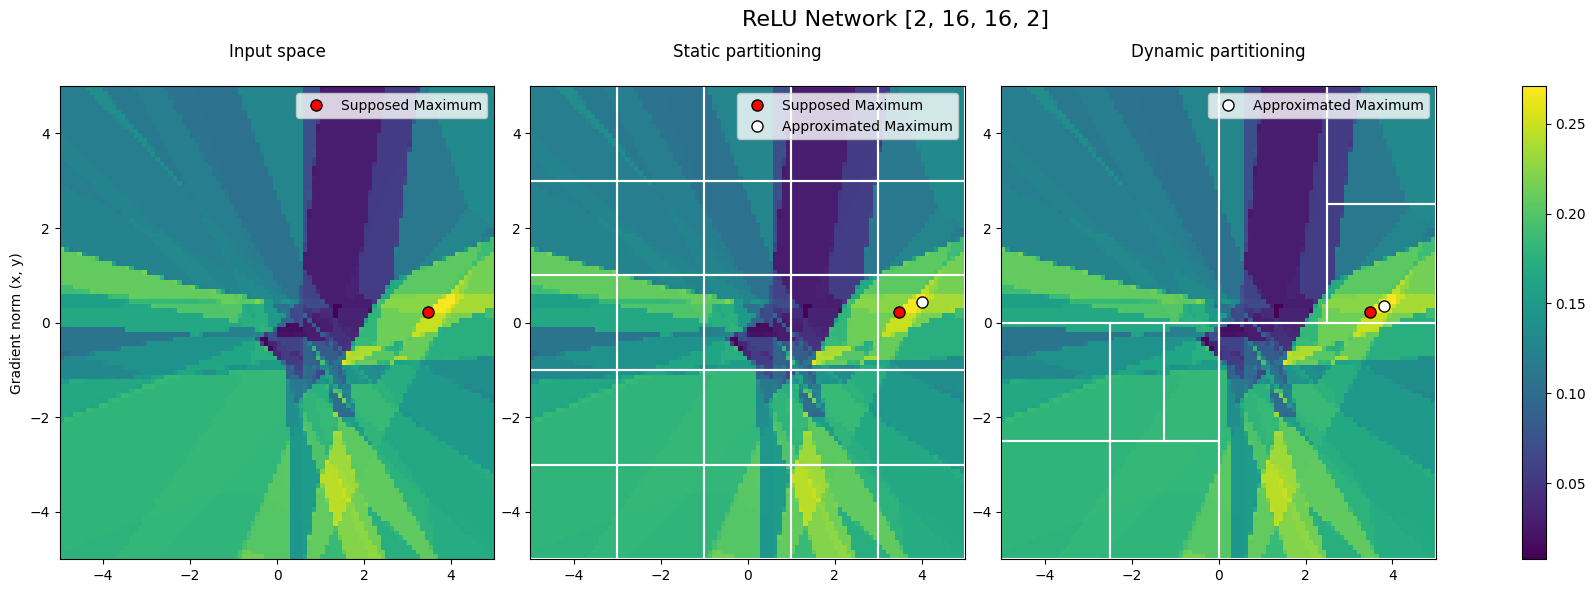

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
grid_x, grid_y = np.mgrid[
                 XS[:, 0].min():XS[:, 0].max():100j,
                 XS[:, 1].min():XS[:, 1].max():100j]
grid_fx = griddata(points=XS, values=GS, xi=(grid_x, grid_y), method='cubic')
im = ax[0].imshow(grid_fx.T,
            extent=(XS[:, 0].min(), XS[:, 0].max(), XS[:, 1].min(), XS[:, 1].max()),
            origin='lower',
            cmap='viridis',
            aspect='auto')
ax[0].set_ylabel('Gradient norm (x, y)')
ax[0].set_xlim((-rad, rad))
ax[0].set_ylim((-rad, rad))
ax[0].set_title(f"Input space\n")
ax[0].plot(maximum_x, maximum_y, 'ro', markersize=8, markeredgecolor='black', label='Supposed Maximum')
ax[0].legend(loc='upper right')


ax[1].imshow(grid_fx.T,
           extent=(XS[:, 0].min(), XS[:, 0].max(), XS[:, 1].min(), XS[:, 1].max()),
           origin='lower',
           cmap='viridis',
           aspect='auto')
ax[1].set_xlim((-rad, rad))
ax[1].set_ylim((-rad, rad))
ax[1].set_title(f"Static partitioning\n")

for r in SA_eq_div.regions:
    x1, y1 = r.lb
    x2, y2 = r.ub
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height,
                             linewidth=1.5,
                             edgecolor='white',
                             facecolor='none')
    ax[1].add_patch(rect)
ax[1].plot(maximum_x, maximum_y, 'ro', markersize=8, markeredgecolor='black', label='Supposed Maximum')
ax[1].plot(SA_eq_div.answer_coords[0], SA_eq_div.answer_coords[1], 'wo', markersize=8, markeredgecolor='black', label='Approximated Maximum')
ax[1].legend(loc='upper right')

ax[2].imshow(grid_fx.T,
           extent=(XS[:, 0].min(), XS[:, 0].max(), XS[:, 1].min(), XS[:, 1].max()),
           origin='lower',
           cmap='viridis',
           aspect='auto')
ax[2].set_xlim((-rad, rad))
ax[2].set_ylim((-rad, rad))
ax[2].set_title(f"Dynamic partitioning\n")

for r in SA_ucb.space.get_leaves():
    x1, y1 = r.lb
    x2, y2 = r.ub
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height,
                             linewidth=1.5,
                             edgecolor='white',
                             facecolor='none')
    ax[2].add_patch(rect)
ax[2].plot(maximum_x, maximum_y, 'ro', markersize=8, markeredgecolor='black')
ax[2].plot(SA_ucb.answer_coords[0], SA_ucb.answer_coords[1], 'wo', markersize=8, markeredgecolor='black', label='Approximated Maximum')
ax[2].legend(loc='upper right')

plt.tight_layout(rect=(0, 0, 1, 0.95))
fig.colorbar(im, ax=ax)
plt.suptitle(f"ReLU Network {network.layer_sizes}", fontsize=16)
plt.show()


### How trained Relu NN "looks" like?
Neural net is trained on a simple synthetic dataset (which looks something like lakes in a forest), just for experimental purposes, to see how gradients of the trained neural net looks like and how our methods perform on them. 

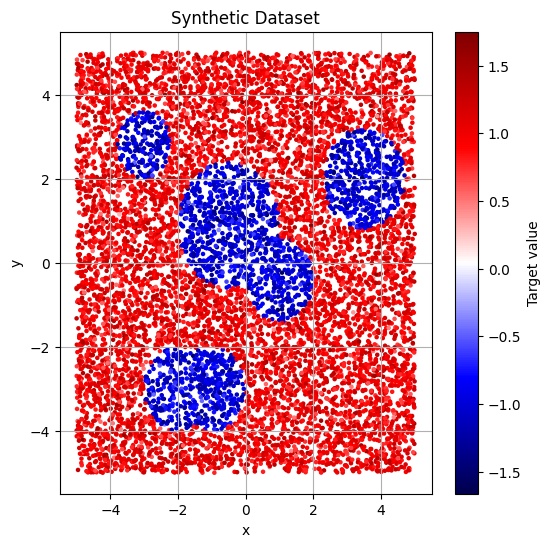

In [21]:
num_points = 10000
X = np.random.uniform(-5, 5, size=(num_points, 2))
X = torch.Tensor(X)

lakes = [((-0.5, 0.9), 1.5), ((-2, -3), 1.0), ((-1, -3), 1), ((3.5, 2), 1.2), ((-3, 2.8), 0.8), ((1, -0.4), 1.0)]

def is_in_region(point):
    return any(np.linalg.norm(point - np.array(center)) < radius for center, radius in lakes)

y = np.array([-1.0 if is_in_region(p) else 1.0 for p in X])
y += np.random.normal(scale=0.2, size=y.shape)
y = torch.Tensor(y)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='seismic', s=5)
plt.colorbar(label="Target value")
plt.title("Synthetic Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [22]:
trained_network = ReLUNet([DIMENSION, 16, 16, 1])
c_vector = torch.Tensor([1.0])

### Before training

maximum = 0.2072080671787262 on (3.499999999999819 3.999999999999808)


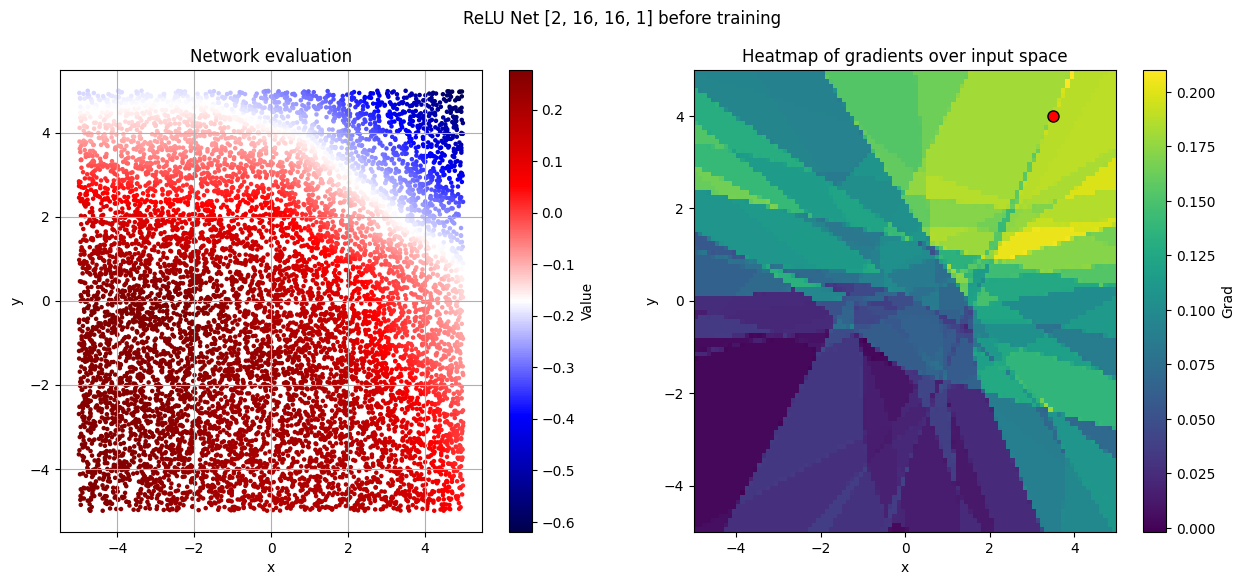

maximum = 0.2072080671787262 on (3.499999999999819 3.999999999999808)
maximum = 0.2072080671787262 on (3.499999999999819 3.999999999999808)


In [23]:
plot_value_and_grads(net=trained_network, domain=domain, radius=rad, dimension=DIMENSION, is_trained=False, px=PIXELS)
XS_untrained, GS_untrained, maximum_untrained, maximum_x_untrained, maximum_y_untrained = get_xs_gs_maximum(net=trained_network, radius=rad, dimension=DIMENSION, px=PIXELS)
pt = domain.random_point(10000)
vals_untrained = trained_network(pt).detach().numpy()

### Train Neural Net

In [32]:
train_X = X[:int(num_points * 0.8)]
train_y = y[:int(num_points * 0.8)].unsqueeze(1)
test_X = X[int(num_points * 0.8):]
test_y = y[int(num_points * 0.8):].unsqueeze(1)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(trained_network.parameters(), lr=1e-3)

epochs = 1000
for epoch in range(epochs):
    trained_network.train()
    pred = trained_network(train_X)
    loss = loss_fn(pred, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        trained_network.eval()
        pred = trained_network(test_X)
        loss = loss_fn(pred, test_y)
        print(f"Epoch {epoch}: Loss: {loss.item():.4f}")

### Or, load pretrained file

In [34]:
# Save the net
import pickle
# with open('trained_net_plots.pkl', 'wb') as f:
#     pickle.dump(trained_network, f)

# Load net 
with open('trained_net_plots.pkl', 'rb') as f:
    trained_network = pickle.load(f)

maximum = 4.986608505249023 on (-2.0600000000000627 0.3799999999998853)


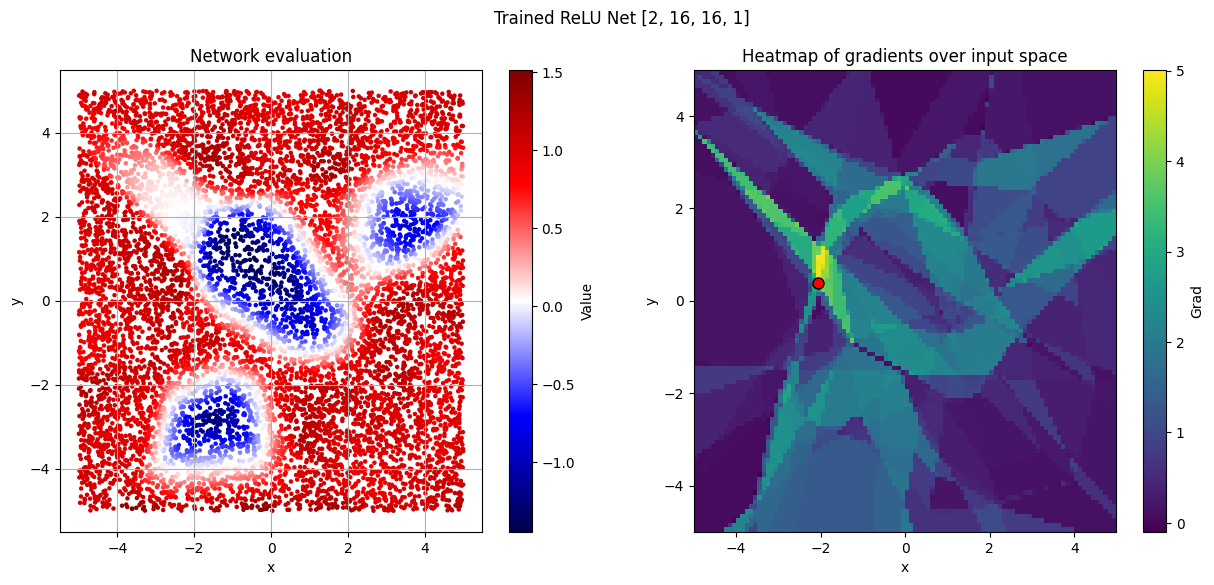

maximum = 4.986608505249023 on (-2.0600000000000627 0.3799999999998853)
maximum = 4.986608505249023 on (-2.0600000000000627 0.3799999999998853)


In [35]:
plot_value_and_grads(net=trained_network, domain=domain, radius=rad, dimension=DIMENSION, is_trained=True, px=PIXELS)
XS_trained, GS_trained, maximum_trained, maximum_x_trained, maximum_y_trained = get_xs_gs_maximum(net=trained_network, radius=rad, dimension=DIMENSION, px=PIXELS)
vals_trained = trained_network(pt).detach().numpy()

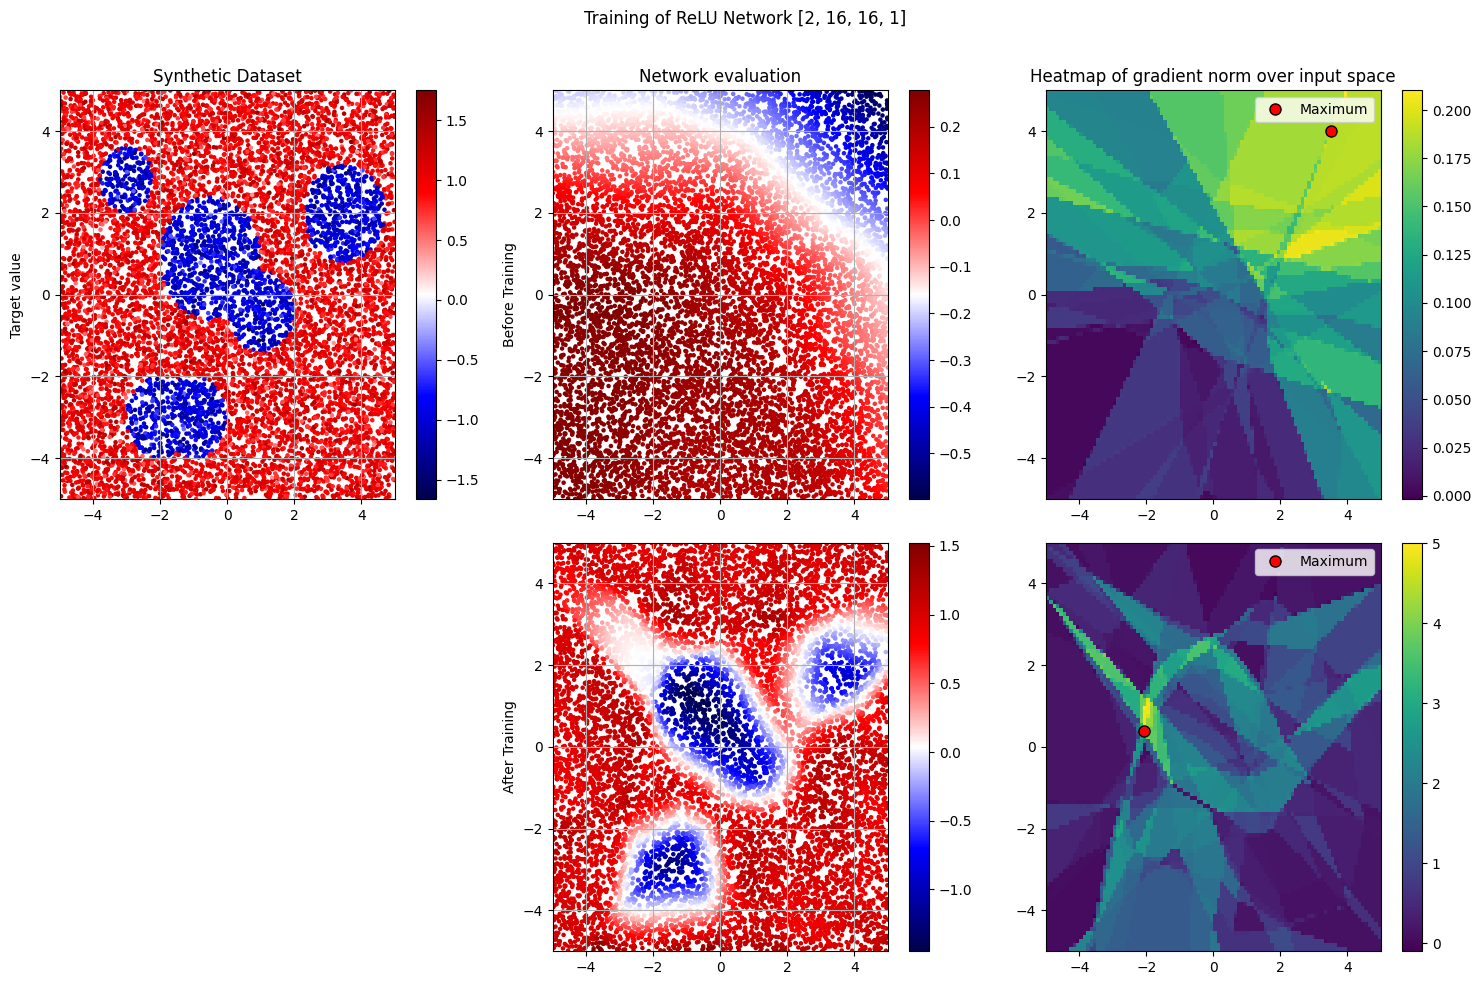

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

ax = ax.flatten()

im = ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap='seismic', s=5)
ax[0].set_title("Synthetic Dataset")
ax[0].set_ylabel("Target value")
ax[0].set_xlim((-rad, rad))
ax[0].set_ylim((-rad, rad))
ax[0].grid(True)
fig.colorbar(im, ax=ax[0])

sc1 = ax[1].scatter(pt[:, 0], pt[:, 1], c=vals_untrained, cmap='seismic', s=5)
fig.colorbar(sc1, ax=ax[1])
ax[1].set_title("Network evaluation")
ax[1].set_ylabel("Before Training")
ax[1].set_xlim((-rad, rad))
ax[1].set_ylim((-rad, rad))
ax[1].grid(True)
grid_x, grid_y = np.mgrid[
                 XS_untrained[:, 0].min():XS_untrained[:, 0].max():100j,
                 XS_untrained[:, 1].min():XS_untrained[:, 1].max():100j]
grid_fx = griddata(points=XS_untrained, values=GS_untrained, xi=(grid_x, grid_y), method='cubic')
im = ax[2].imshow(grid_fx.T,
                  extent=(XS_untrained[:, 0].min(), XS_untrained[:, 0].max(), XS_untrained[:, 1].min(), XS_untrained[:, 1].max()),
                  origin='lower',
                  cmap='viridis',
                  aspect='auto')
fig.colorbar(im, ax=ax[2])
ax[2].set_xlim((-rad, rad))
ax[2].set_ylim((-rad, rad))
ax[2].set_title('Heatmap of gradient norm over input space')
ax[2].grid(False)
ax[2].plot(maximum_x_untrained, maximum_y_untrained, 'ro', markersize=8, markeredgecolor='black', label='Maximum')
ax[2].legend(loc='upper right')


ax[3].axis('off')

sc1 = ax[4].scatter(pt[:, 0], pt[:, 1], c=vals_trained, cmap='seismic', s=5)
fig.colorbar(sc1, ax=ax[4])
ax[4].set_ylabel("After Training")
ax[4].set_xlim((-rad, rad))
ax[4].set_ylim((-rad, rad))
ax[4].grid(True)
grid_x, grid_y = np.mgrid[
                 XS_trained[:, 0].min():XS_trained[:, 0].max():100j,
                 XS_trained[:, 1].min():XS_trained[:, 1].max():100j]
grid_fx = griddata(points=XS_trained, values=GS_trained, xi=(grid_x, grid_y), method='cubic')
im = ax[5].imshow(grid_fx.T,
                  extent=(XS_trained[:, 0].min(), XS_trained[:, 0].max(), XS_trained[:, 1].min(), XS_trained[:, 1].max()),
                  origin='lower',
                  cmap='viridis',
                  aspect='auto')
fig.colorbar(im, ax=ax[5])
ax[5].set_xlim((-rad, rad))
ax[5].set_ylim((-rad, rad))
ax[5].grid(False)
ax[5].plot(maximum_x_trained, maximum_y_trained, 'ro', markersize=8, markeredgecolor='black', label='Maximum')
ax[5].legend(loc='upper right')

fig.suptitle(f"Training of ReLU Network {trained_network.layer_sizes}")
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [37]:
XS, GS, maximum, maximum_x, maximum_y = get_xs_gs_maximum(net=trained_network, radius=rad, dimension=DIMENSION, px=PIXELS)

maximum = 4.986608505249023 on (-2.0600000000000627 0.3799999999998853)


In [38]:
SA_eq_div = StochasticApproximationEqDiv(network=trained_network, c_vector=c_vector, domain=domain, divisions_per_dimension=5)
eq_div_result = SA_eq_div.compute(v=False, total_iterations=100000, track_evaluations=True, exact=None)
print(f"SA with Equal space partition\n"
      f"\tresult = {eq_div_result} ({(maximum - eq_div_result) / maximum * 100:.2f}%)\n"
      f"\titerations = {SA_eq_div.iteration_count}\n"
      f"\tcompute time = {SA_eq_div.compute_time:.2f} seconds\n"
      f"\ton = {SA_eq_div.answer_coords}")

SA with Equal space partition
	result = 4.986608505249023 (0.00%)
	iterations = 100000
	compute time = 7.04 seconds
	on = [-2.0525002   0.40615368]


SA with MCTS
	result = 4.986608505249023 (0.00%)
	iterations = 100000
	compute time = 24.48 seconds
	on = [-2.0253634   0.44187173]


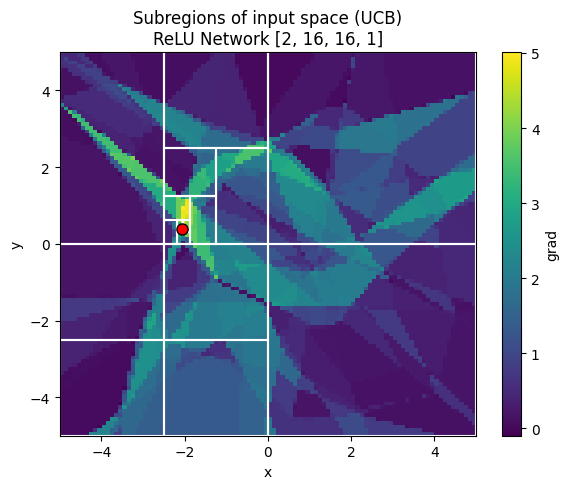

In [39]:
SA_ucb = StochasticApproximationUCBDynamic(network=trained_network, c_vector=c_vector, domain=domain, c=1, partition_step=2)
ucb_result = SA_ucb.compute(v=False, max_iter=100000, exact=None)
print(f"SA with MCTS\n"
      f"\tresult = {ucb_result.item()} ({(maximum-ucb_result.numpy()[0])/maximum*100:.2f}%)\n"
      f"\titerations = {SA_ucb.iteration_count}\n"
      f"\tcompute time = {SA_ucb.compute_time:.2f} seconds\n"
      f"\ton = {SA_ucb.answer_coords}")

plot_fixed_partitions_grads(net=trained_network, radius=rad, regs=SA_ucb.space.get_leaves(), xs=XS, gs=GS, mxx=maximum_x, mxy=maximum_y, description="UCB")

In [40]:
simple_prob = LipMIP(trained_network, domain, c_vector=torch.tensor([1.0]), verbose=False, num_threads=5)
simple_result = simple_prob.compute_max_lipschitz()
LipMIP_result = simple_result.as_dict()["value"]
simple_result.as_dict()["value"]

4.986610425914763

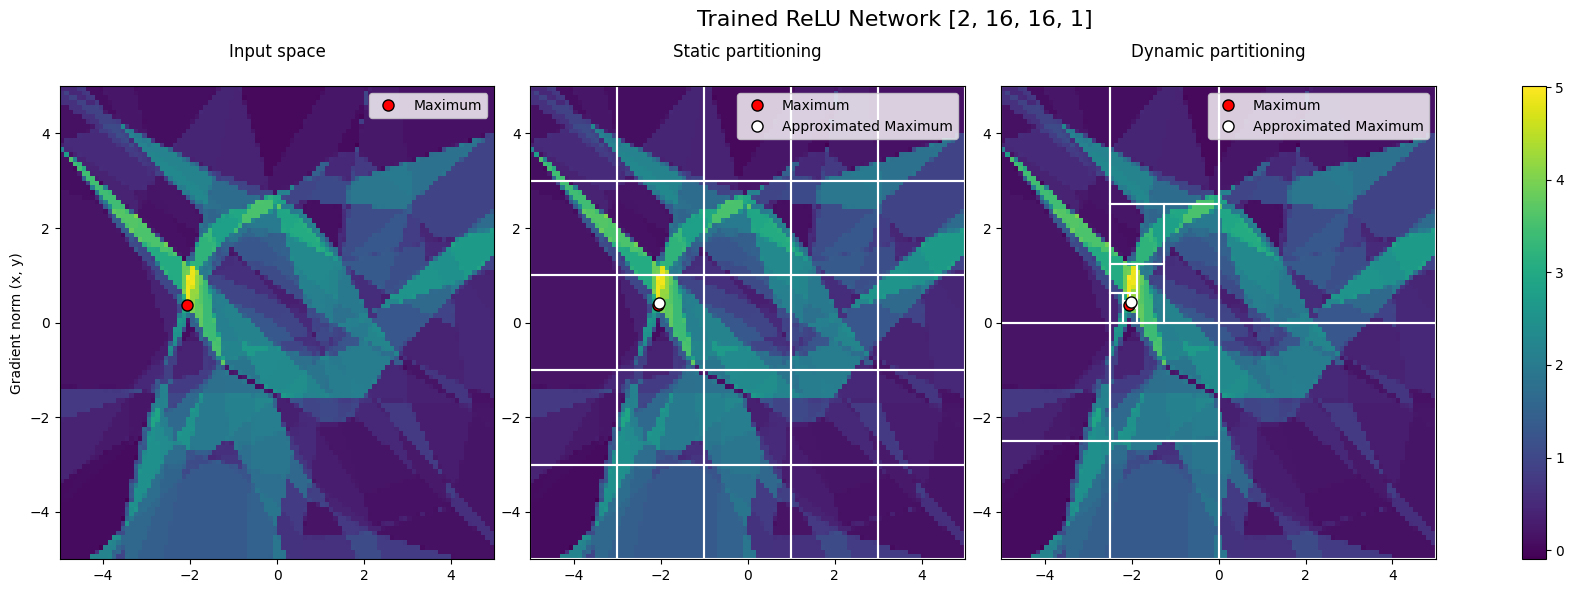

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
grid_x, grid_y = np.mgrid[
                 XS[:, 0].min():XS[:, 0].max():100j,
                 XS[:, 1].min():XS[:, 1].max():100j]
grid_fx = griddata(points=XS, values=GS, xi=(grid_x, grid_y), method='cubic')
im = ax[0].imshow(grid_fx.T,
            extent=(XS[:, 0].min(), XS[:, 0].max(), XS[:, 1].min(), XS[:, 1].max()),
            origin='lower',
            cmap='viridis',
            aspect='auto')
ax[0].set_ylabel('Gradient norm (x, y)')
ax[0].set_xlim((-rad, rad))
ax[0].set_ylim((-rad, rad))
ax[0].set_title(f"Input space\n")
ax[0].plot(maximum_x, maximum_y, 'ro', markersize=8, markeredgecolor='black', label='Maximum')
ax[0].legend(loc='upper right')


ax[1].imshow(grid_fx.T,
           extent=(XS[:, 0].min(), XS[:, 0].max(), XS[:, 1].min(), XS[:, 1].max()),
           origin='lower',
           cmap='viridis',
           aspect='auto')
ax[1].set_xlim((-rad, rad))
ax[1].set_ylim((-rad, rad))
ax[1].set_title(f"Static partitioning\n")

for r in SA_eq_div.regions:
    x1, y1 = r.lb
    x2, y2 = r.ub
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height,
                             linewidth=1.5,
                             edgecolor='white',
                             facecolor='none')
    ax[1].add_patch(rect)
ax[1].plot(maximum_x, maximum_y, 'ro', markersize=8, markeredgecolor='black', label='Maximum')
ax[1].plot(SA_eq_div.answer_coords[0], SA_eq_div.answer_coords[1], 'wo', markersize=8, markeredgecolor='black', label='Approximated Maximum')
ax[1].legend(loc='upper right')


ax[2].imshow(grid_fx.T,
           extent=(XS[:, 0].min(), XS[:, 0].max(), XS[:, 1].min(), XS[:, 1].max()),
           origin='lower',
           cmap='viridis',
           aspect='auto')
ax[2].set_xlim((-rad, rad))
ax[2].set_ylim((-rad, rad))
ax[2].set_title(f"Dynamic partitioning\n")

for r in SA_ucb.space.get_leaves():
    x1, y1 = r.lb
    x2, y2 = r.ub
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height,
                             linewidth=1.5,
                             edgecolor='white',
                             facecolor='none')
    ax[2].add_patch(rect)
ax[2].plot(maximum_x, maximum_y, 'ro', markersize=8, markeredgecolor='black', label='Maximum')
ax[2].plot(SA_ucb.answer_coords[0], SA_ucb.answer_coords[1], 'wo', markersize=8, markeredgecolor='black', label='Approximated Maximum')
ax[2].legend(loc='upper right')

plt.tight_layout(rect=(0, 0, 1, 0.95))
fig.colorbar(im, ax=ax)
plt.suptitle(f"Trained ReLU Network {trained_network.layer_sizes}", fontsize=16)
plt.show()

In [42]:
SA_ = StochasticApproximationEqDiv(network=trained_network, c_vector=c_vector, domain=domain, divisions_per_dimension=1)
_result = SA_.compute(v=False, total_iterations=100000, track_evaluations=True, exact=None)
print(f"SA with no partitioning\n"
      f"\tresult = {_result} ({(maximum - _result) / maximum * 100:.2f}%)\n"
      f"\titerations = {SA_.iteration_count}\n"
      f"\tcompute time = {SA_.compute_time:.2f} seconds\n"
      f"\ton = {SA_.answer_coords}")

SA with no partitioning
	result = 4.986608505249023 (0.00%)
	iterations = 100000
	compute time = 8.04 seconds
	on = [-2.0212831   0.45893407]


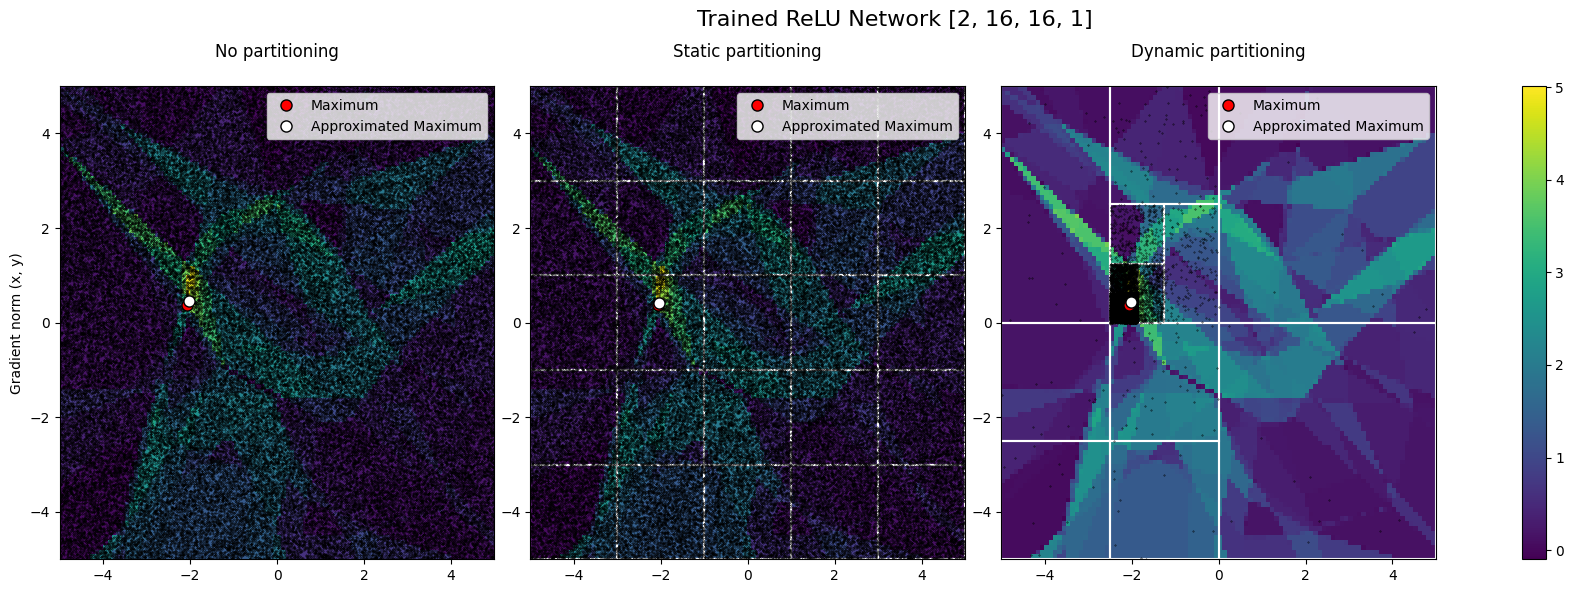

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
grid_x, grid_y = np.mgrid[
                 XS[:, 0].min():XS[:, 0].max():100j,
                 XS[:, 1].min():XS[:, 1].max():100j]
grid_fx = griddata(points=XS, values=GS, xi=(grid_x, grid_y), method='cubic')
im = ax[0].imshow(grid_fx.T,
            extent=(XS[:, 0].min(), XS[:, 0].max(), XS[:, 1].min(), XS[:, 1].max()),
            origin='lower',
            cmap='viridis',
            aspect='auto')
ax[0].set_ylabel('Gradient norm (x, y)')
ax[0].set_xlim((-rad, rad))
ax[0].set_ylim((-rad, rad))
ax[0].set_title(f"No partitioning\n")

ax[0].scatter(np.array(SA_.eval_list)[:, 0], np.array(SA_.eval_list)[:, 1], c='k', s=0.1)
ax[0].plot(maximum_x, maximum_y, 'ro', markersize=8, markeredgecolor='black', label='Maximum')
ax[0].plot(SA_.answer_coords[0], SA_.answer_coords[1], 'wo', markersize=8, markeredgecolor='black', label='Approximated Maximum')
ax[0].legend(loc='upper right')


ax[1].imshow(grid_fx.T,
           extent=(XS[:, 0].min(), XS[:, 0].max(), XS[:, 1].min(), XS[:, 1].max()),
           origin='lower',
           cmap='viridis',
           aspect='auto')
ax[1].set_xlim((-rad, rad))
ax[1].set_ylim((-rad, rad))
ax[1].set_title(f"Static partitioning\n")

for r in SA_eq_div.regions:
    x1, y1 = r.lb
    x2, y2 = r.ub
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height,
                             linewidth=1.5,
                             edgecolor='white',
                             facecolor='none')
    ax[1].add_patch(rect)
    
ax[1].scatter(np.array(SA_eq_div.eval_list)[:, 0], np.array(SA_eq_div.eval_list)[:, 1], c='k', s=0.1)
ax[1].plot(maximum_x, maximum_y, 'ro', markersize=8, markeredgecolor='black', label='Maximum')
ax[1].plot(SA_eq_div.answer_coords[0], SA_eq_div.answer_coords[1], 'wo', markersize=8, markeredgecolor='black', label='Approximated Maximum')
ax[1].legend(loc='upper right')


ax[2].imshow(grid_fx.T,
           extent=(XS[:, 0].min(), XS[:, 0].max(), XS[:, 1].min(), XS[:, 1].max()),
           origin='lower',
           cmap='viridis',
           aspect='auto')
ax[2].set_xlim((-rad, rad))
ax[2].set_ylim((-rad, rad))
ax[2].set_title(f"Dynamic partitioning\n")

for r in SA_ucb.space.get_leaves():
    x1, y1 = r.lb
    x2, y2 = r.ub
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height,
                             linewidth=1.5,
                             edgecolor='white',
                             facecolor='none')
    ax[2].add_patch(rect)

ax[2].scatter(np.array(SA_ucb.space.evaluations)[:, 0], np.array(SA_ucb.space.evaluations)[:, 1], c='k', s=0.1)
ax[2].plot(maximum_x, maximum_y, 'ro', markersize=8, markeredgecolor='black', label='Maximum')
ax[2].plot(SA_ucb.answer_coords[0], SA_ucb.answer_coords[1], 'wo', markersize=8, markeredgecolor='black', label='Approximated Maximum')
ax[2].legend(loc='upper right')

plt.tight_layout(rect=(0, 0, 1, 0.95))
fig.colorbar(im, ax=ax)
plt.suptitle(f"Trained ReLU Network {trained_network.layer_sizes}", fontsize=16)
plt.show()